# Lab 02: Softmax Regression

Nói gì hong ta

## 1. Import thư viện cần thiết

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load **Dataset MNIST** 
Trực tiếp từ thư viện *tensorflow.keras.datasets*

In [165]:
from tensorflow.keras.datasets import mnist

In [166]:
def load_mnist(flatten=True, normalize=True):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype(np.float32)
    x_test  = x_test.astype(np.float32)

    return x_train, y_train, x_test, y_test

## 3. Pre-Processing

In [167]:
x_train_raw, y_train_raw, x_test_raw, y_test_raw = load_mnist()
X_all = np.concatenate([x_train_raw, x_test_raw], axis=0)
y_all = np.concatenate([y_train_raw, y_test_raw], axis=0)

### 3.1 Thống kê cơ bản (Basic statistics)

*Số lượng mẫu, số chiều ảnh, min/max, mean, std*

In [168]:
print("Number of samples:", X_all.shape[0])
print("Image shape:", X_all.shape[1:])
print("Pixel range:", X_all.min(), "-", X_all.max())
print("Mean pixel value:", X_all.mean())
print("Std of pixel values:", X_all.std())

Number of samples: 70000
Image shape: (28, 28)
Pixel range: 0.0 - 255.0
Mean pixel value: 33.38596
Std of pixel values: 78.654396


*Kiểm tra NaN, Inf*

In [169]:
print("Has NaN:", np.isnan(X_all).any())
print("Has Inf:", np.isinf(X_all).any())

Has NaN: False
Has Inf: False


### Phân phối nhãn (Label distribution)

In [170]:
unique, counts = np.unique(y_all, return_counts=True)
total_samples = y_all.shape[0]

print(f"{'Label':<10} {'Count':<10} {'Percentage':<15}")
print("-" * 35)
for label, count in zip(unique, counts):
    percent = (count / total_samples) * 100
    print(f"{label:<10} {count:<10} {percent:.2f}%")

Label      Count      Percentage     
-----------------------------------
0          6903       9.86%
1          7877       11.25%
2          6990       9.99%
3          7141       10.20%
4          6824       9.75%
5          6313       9.02%
6          6876       9.82%
7          7293       10.42%
8          6825       9.75%
9          6958       9.94%


==> Dữ liệu khá cân bằng, ta sẽ dùng Barplot để nhìn rõ hơn

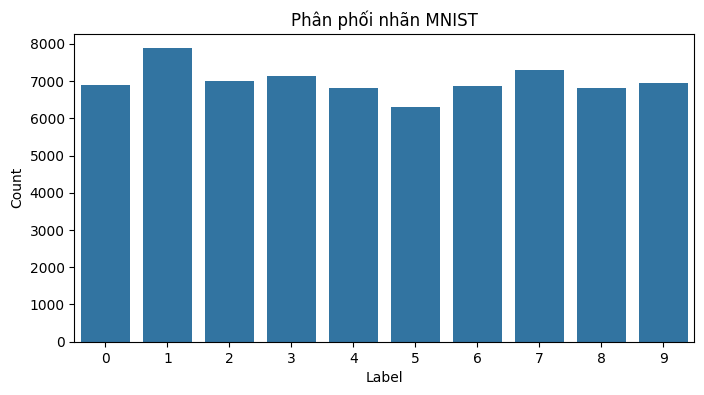

In [171]:
plt.figure(figsize=(8,4))
sns.countplot(x=y_all)
plt.title("Phân phối nhãn MNIST")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Quan sát dữ liệu

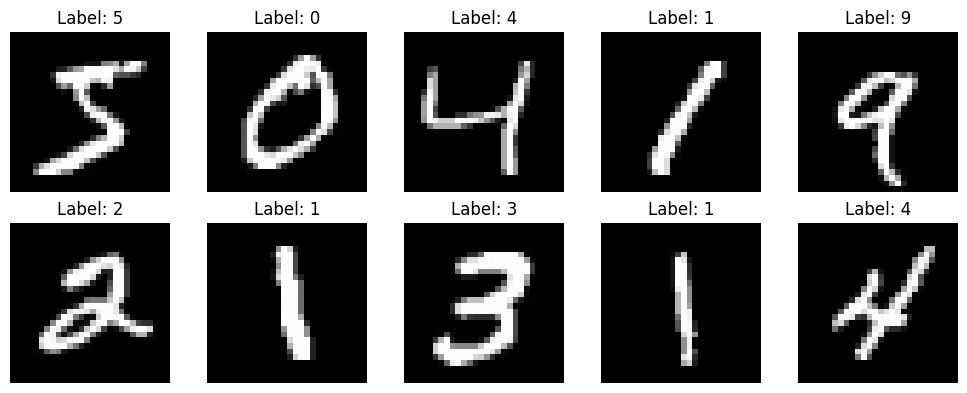

In [172]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_all[i], cmap='gray')
    plt.title(f"Label: {y_all[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Thống kê pixel trung bình theo lớp (Mean image per class)

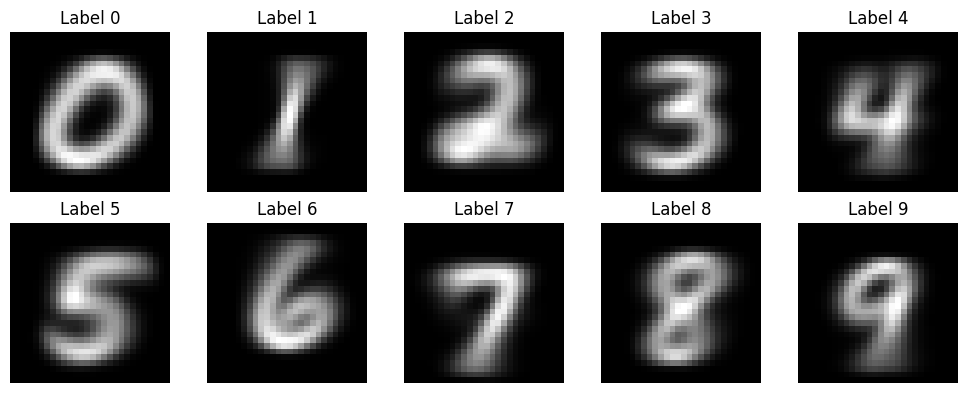

In [173]:
mean_images = []
for label in np.unique(y_all):
    mean_img = X_all[y_all == label].mean(axis=0)
    mean_images.append(mean_img)

plt.figure(figsize=(10,4))
for i, img in enumerate(mean_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Histogram pixel (Pixel intensity distribution)

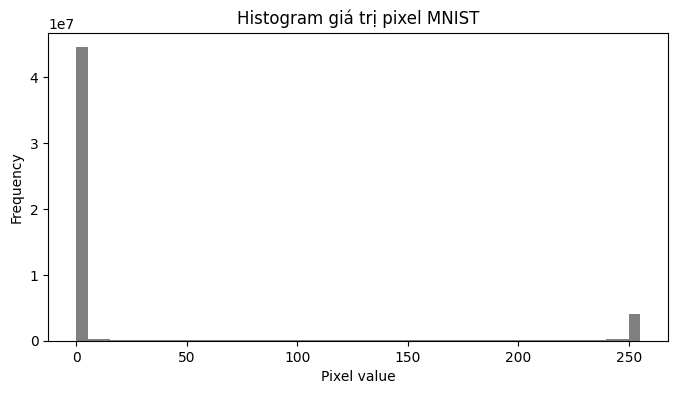

In [174]:
plt.figure(figsize=(8,4))
plt.hist(X_all.ravel(), bins=50, color='gray')
plt.title("Histogram giá trị pixel MNIST")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

### Correlation heatmap (Của 1000 ảnh đầu)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


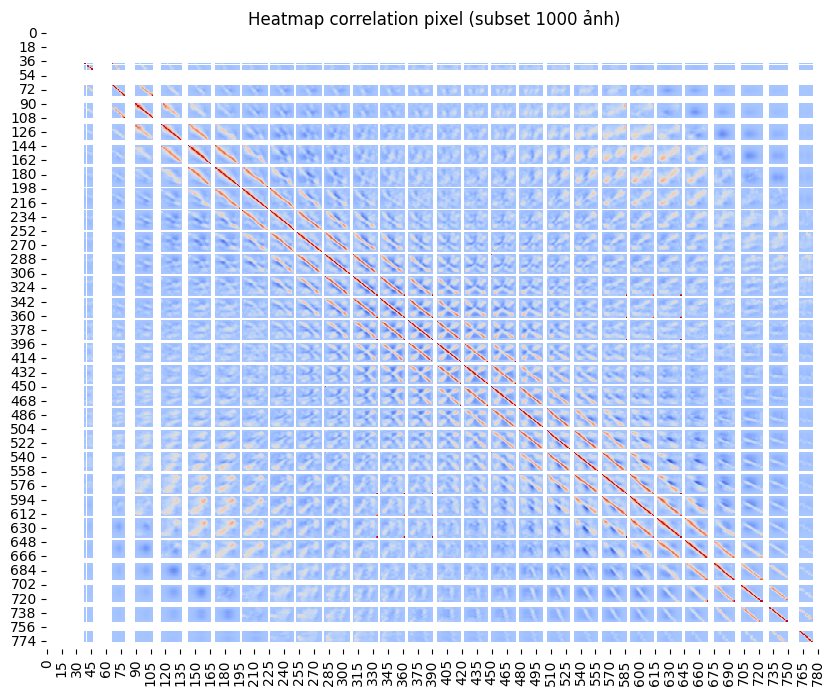

In [175]:
subset = X_all[:1000].reshape(1000, -1)
corr = np.corrcoef(subset.T)  # pixel correlation
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', cbar=False)
plt.title("Heatmap correlation pixel (subset 1000 ảnh)")
plt.show()

## 4. Trích xuất đặc trưng ảnh
Để Model huấn luyện được ta cần cung cấp:
- Normalized pixel intensity features
- Edge or contour-based features using image filters
- Dimensionality reduction or handcrafted features (e.g., PCA, block averaging, etc.)
- ...

### 4.1 Normalized

In [176]:

def normalized_pixels(X):

    return X / 255.0 


### 4.2 Chuẩn hoá Edge
Dùng cả hai sobel và canny

In [177]:
import cv2
import numpy as np

def sobel_edge_features(X):
    
    # 1. Tính cạnh
    edges = np.array([
        np.sqrt(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)**2 + 
                cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)**2)
        for img in X
    ], dtype=np.float32)
    
    # 2. Chuẩn hóa cạnh về 0-1
    edges = np.array([e / (e.max() + 1e-8) for e in edges], dtype=np.float32)
    
    return edges

def canny_edge_features(X):
    # 1. Canny yêu cầu đầu vào là uint8 (0-255)
    if X.dtype != np.uint8:
        X_uint8 = X.astype(np.uint8)
    else:
        X_uint8 = X

    # 2. Áp dụng Canny cho từng bức ảnh trong batch
    edges = np.array([cv2.Canny(img, 100, 200) for img in X_uint8], dtype=np.float32)
    
    edges = np.array([e / 255.0 for e in edges], dtype=np.float32)

    return edges




### 4.3 Block Averaging

In [178]:
def block_averaging(X, block_size=2):
    # 1. Xử lý linh hoạt đầu vào (số nguyên hoặc tuple đều được)
    if isinstance(block_size, int):
        bh = bw = block_size
    else:
        bh, bw = block_size
        
    N, H, W = X.shape
    print(N, H, W)

    # 2. Tính kích thước mới (bỏ qua phần dư thừa nếu ảnh ko chia hết)
    new_h = H // bh
    new_w = W // bw
    
    # Kích thước thực tế sẽ dùng để cắt ảnh
    valid_h = new_h * bh
    valid_w = new_w * bw

    # 3. Cắt ảnh (Crop) để đảm bảo chia hết cho block_size
    X_cropped = X[:, :valid_h, :valid_w]

    # 4. Reshape thành lưới 5 chiều
    blocked = X_cropped.reshape(N, new_h, bh, new_w, bw)

    # 5. TÍNH TRUNG BÌNH (MEAN)
    return blocked.mean(axis=(2, 4))

## 5. Feature Vector Designs

### 5.1 Hàm visualize

In [179]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_universal(idx, X_origin, X_processed):
    # Lấy vector đặc trưng của ảnh thứ idx
    feature_vector = X_processed[idx]
    vector_len = feature_vector.shape[0] # Ví dụ 784 hoặc 1568
    
    img_origin = X_origin[idx]
    
    plt.figure(figsize=(10, 4))
    
    # --- TRƯỜNG HỢP 1: DESIGN 1 (Chỉ 784 features) ---
    if vector_len == 784:
        # Reshape về 28x28
        img_reconstructed = feature_vector.reshape(28, 28)
        
        plt.subplot(1, 2, 1); plt.imshow(img_origin, cmap='gray'); plt.title("Ảnh gốc")
        plt.subplot(1, 2, 2); plt.imshow(img_reconstructed, cmap='gray'); plt.title("Normalized (28 * 28)")

    # --- TRƯỜNG HỢP 2: DESIGN 2 (1568 features - Có Sobel/Canny) ---
    elif vector_len == 1568:
        # Reshape về 28x28x2
        img_reconstructed = feature_vector.reshape(28, 28, 2)
        
        # Tách kênh
        ch_edges    = img_reconstructed[:, :, 1]
        
        plt.subplot(1, 2, 1); plt.imshow(img_origin, cmap='gray'); plt.title("Ảnh gốc")
        plt.subplot(1, 2, 2); plt.imshow(ch_edges, cmap='gray'); plt.title("Edges (28 * 28)")

    # ---  TRƯỜNG HỢP 3:  DESIGN 3 Block Averaging (Size 49) ---
    elif vector_len == 196: # 7x7 = 49
        img_reconstructed = feature_vector.reshape(14, 14)
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_origin, cmap='gray')
        plt.title("Ảnh gốc (28x28)")
        
        plt.subplot(1, 2, 2)
        plt.imshow(img_reconstructed, cmap='gray')
        # Tắt chế độ làm mượt để thấy rõ hiệu ứng pixel
        plt.title("Block Averaging (14x14)")
        
    else:
        print(f"Kích thước {vector_len} lạ quá, không biết vẽ sao!")
        
    plt.tight_layout()
    plt.show()

### 5.1 Function 1

*Feature engineering*

In [180]:


def function1(x_train, y_train, x_test, y_test):

    # --- 1. CHUẨN BỊ ẢNH GỐC (BASE) ---
    x_train_nor = normalized_pixels(x_train)
    x_test_nor  = normalized_pixels(x_test)
    
    # --- 2. DUỖI PHẲNG (FLATTEN) ---
    x_new_train = x_train_nor.reshape(len(x_train_nor), -1)  # (60000, 784)
    x_new_test  = x_test_nor.reshape(len(x_test_nor), -1)    # (10000, 784)
    
    
    return x_new_train, y_train, x_new_test, y_test

### 5.2 Function 2


Trong function 2 là sự kết hợp của chuẩn hoá nomalized, với edges. Output đầu ra là mảng 1 chiều. Tất cả các ảnh có sự hợp lại so với ảnh ban đầu

In [181]:
import numpy as np

def function2(x_train, y_train, x_test, y_test, method='sobel'):
    # --- 1. CHUẨN BỊ ẢNH GỐC (BASE) ---
    x_train_nor = normalized_pixels(x_train)
    x_test_nor  = normalized_pixels(x_test)

    x_train_edges = None
    x_test_edges  = None

    # --- 2. TÍNH TOÁN CẠNH (FEATURE ENGINEERING) ---
    if method == 'sobel':
        x_train_edges = sobel_edge_features(x_train_nor) 
        x_test_edges  = sobel_edge_features(x_test_nor)

    elif method == 'canny':
        x_train_edges = canny_edge_features(x_train)
        x_test_edges  = canny_edge_features(x_test)

    # --- 3. HỢP NHẤT (STACKING) ---
    if x_train_edges is not None:
        X_new_train = np.stack([x_train_nor, x_train_edges], axis=-1)
        X_new_test  = np.stack([x_test_nor, x_test_edges], axis=-1)
    else:
        X_new_train = x_train_nor[..., np.newaxis]
        X_new_test  = x_test_nor[..., np.newaxis]

    # --- 4. DUỖI PHẲNG (FLATTEN) ---
    x_new_train = X_new_train.reshape(X_new_train.shape[0], -1)
    x_new_test  = X_new_test.reshape(X_new_test.shape[0], -1)
    
    # --- 5. SO SÁNH VỚI ẢNH MỚI ---
    visualize_universal(0, x_train, x_new_train)
    
    return x_new_train, y_train, x_new_test, y_test


### 5.3 Function 3

*Feature engineering*

In [182]:
# block averaging
def function3(x_train, y_train, x_test, y_test):
    
     # --- 1. CHUẨN BỊ ẢNH GỐC (BASE) ---
    x_train_nor = normalized_pixels(x_train)
    x_test_nor  = normalized_pixels(x_test)

    # --- 2. BLOCK AVERAGING ---
    x_train_avg = block_averaging(x_train_nor)
    x_test_avg = block_averaging(x_test_nor)

    # --- 4. DUỖI PHẲNG (FLATTEN) ---
    x_new_train = x_train_avg.reshape(len(x_train_avg), -1)
    x_new_test = x_test_avg.reshape(len(x_test_avg), -1)
    
    # --- 5. SO SÁNH VỚI ẢNH MỚI ---
    visualize_universal(0, x_train, x_new_train)
    
    return x_new_train, y_train, x_new_test, y_test


## 6. Cài đặt Model
### SoftmaxRegression bao gồm:
- `__init__`: Khởi tạo tham số, trọng số, bias, history
- `_softmax`: Hàm softmax
- `_one_hot`: Chuyển nhãn sang one-hot
- `_compute_accuracy`: Tính độ chính xác
- `_cross_entropy_loss`: Tính cross-entropy loss
- `fit`: Huấn luyện mô hình
- `predict`: Dự đoán nhãn
- `predict_proba`: Dự đoán xác suất
- `evaluate`: Đánh giá mô hình


In [183]:
class SoftmaxRegression:
    def __init__(self, num_classes=10, lr=0.1, num_epochs=2000, batch_size=128):
        self.num_classes = num_classes
        self.lr = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.W = None
        self.b = None
        self.history = {
            'loss': [],
            'train_acc': [],
            'val_acc': []
        }
    def _softmax(self, z):
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot(self, y):
        N = y.shape[0]
        y_oh = np.zeros((N, self.num_classes))
        y_oh[np.arange(N), y] = 1
        return y_oh
    
    def _compute_accuracy(self, X, y):
        probs = self._softmax(np.dot(X, self.W) + self.b)
        preds = np.argmax(probs, axis=1)
        return np.mean(preds == y)

    def _cross_entropy_loss(self, probs, y_oh):
        N = probs.shape[0]
        return -np.sum(y_oh * np.log(probs + 1e-9)) / N
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        N, D = X_train.shape

        if self.W is None:
            self.W = 0.01 * np.random.randn(D, self.num_classes).astype(np.float32)
            self.b = np.zeros((1, self.num_classes), dtype=np.float32)

        y_train_oh = self._one_hot(y_train)
        num_batches = int(np.ceil(N / self.batch_size))

        for epoch in range(self.num_epochs):
            indices = np.random.permutation(N)
            X_train_shuffled = X_train[indices]
            y_train_oh_shuffled = y_train_oh[indices]

            epoch_loss = 0

            for i in range(num_batches):
                start = i * self.batch_size
                end = min((i + 1) * self.batch_size, N)

                X_batch = X_train_shuffled[start:end]
                y_batch_oh = y_train_oh_shuffled[start:end]
                B = X_batch.shape[0]

                logits = np.dot(X_batch, self.W) + self.b
                probs = self._softmax(logits)

                batch_loss = self._cross_entropy_loss(probs, y_batch_oh)
                epoch_loss += batch_loss

                dlogits = (probs - y_batch_oh) / B
                dW = np.dot(X_batch.T, dlogits)
                db = np.sum(dlogits, axis=0, keepdims=True)

                self.W -= self.lr * dW
                self.b -= self.lr * db

            avg_loss = epoch_loss / num_batches
            train_acc = self._compute_accuracy(X_train, y_train)

            self.history['loss'].append(avg_loss)
            self.history['train_acc'].append(train_acc)

            if epoch % 10 == 0:
                msg = f"Epoch {epoch+1}/{self.num_epochs} - loss={avg_loss:.4f} - train_acc={train_acc:.4f}"

                if X_val is not None and y_val is not None:
                    val_acc = self._compute_accuracy(X_val, y_val)
                    self.history['val_acc'].append(val_acc)
                    msg += f" - val_acc={val_acc:.4f}"

                print(msg)
    def predict(self, X):
        probs = self._softmax(np.dot(X, self.W) + self.b)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        return self._softmax(np.dot(X, self.W) + self.b)

    def evaluate(self, X, y):
        probs = self._softmax(np.dot(X, self.W) + self.b)
        y_oh = self._one_hot(y)
        loss = self._cross_entropy_loss(probs, y_oh)
        acc = np.mean(np.argmax(probs, axis=1) == y)
        return loss, acc
    
model = SoftmaxRegression(
    num_classes=10,
    lr=0.1,
    num_epochs=50,
    batch_size=128
)

## 7. Evaluation

In [184]:
#TODO: YOUR CODE HERE
def calculate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


## 8. Main
Các cell chỉ khác ở ô set-up, mọi người tự copy paste cho những version sau

### 8.1 Function 1 (Mẫu)

*Set-up*

In [185]:
X_train, y_train, X_test, y_test = load_mnist()

X_train_1, y_train_1, X_test_1, y_test_1 = function1(X_train, y_train, X_test, y_test)

print(f"Train shape: {X_train_1.shape}, Labels: {y_train_1.shape}")


Train shape: (60000, 784), Labels: (60000,)


*Train*

In [186]:
print("\nTraining:")
model.fit(X_train_1, y_train_1)


Training:
Epoch 1/50 - loss=0.5732 - train_acc=0.8933
Epoch 11/50 - loss=0.2875 - train_acc=0.9217
Epoch 21/50 - loss=0.2715 - train_acc=0.9261
Epoch 31/50 - loss=0.2637 - train_acc=0.9279
Epoch 41/50 - loss=0.2588 - train_acc=0.9291


*Test*

In [187]:
print("\nTest:")
predictions = model.predict(X_test_1)
acc = calculate_accuracy(y_test_1, predictions)
print(f"Test Accuracy: {acc * 100:.2f}%")


Test:
Test Accuracy: 92.53%


*Trực quan hóa và Báo cáo kết quả*

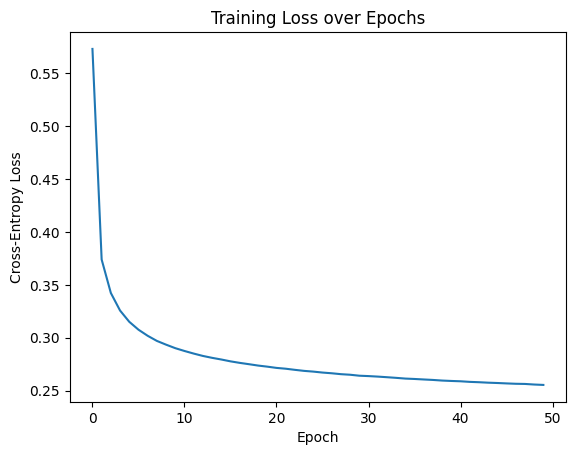

Test Loss: 0.2664, Test Accuracy: 92.53%


In [188]:
plt.plot(model.history['loss'])
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()


test_loss, test_acc = model.evaluate(X_test_1, y_test_1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

### 8.2 Edges

set up

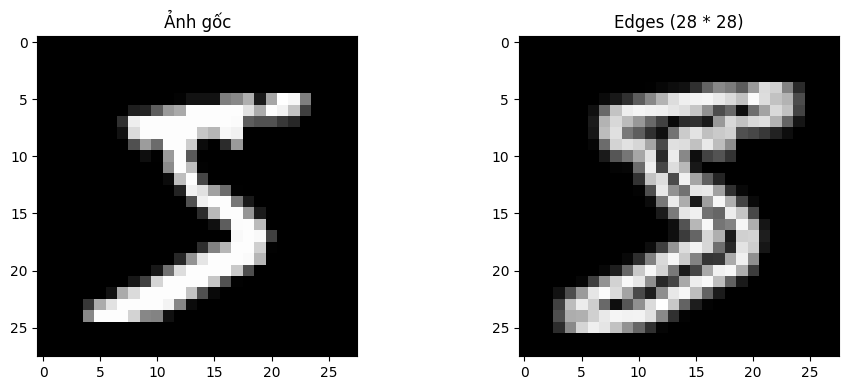

Train shape: (60000, 1568), Labels: (60000,)


In [189]:

X_train_2, y_train_2, X_test_2, y_test_2 = function2(X_train, y_train, X_test, y_test)

print(f"Train shape: {X_train_2.shape}, Labels: {y_train_2.shape}")

Train

In [190]:
model2 = SoftmaxRegression(
    num_classes=10,
    lr=0.1,
    num_epochs=50,
    batch_size=128
)

print("\nTraining:")
model2.fit(X_train_2, y_train_2)


Training:
Epoch 1/50 - loss=0.4728 - train_acc=0.9076
Epoch 11/50 - loss=0.2237 - train_acc=0.9385
Epoch 21/50 - loss=0.2018 - train_acc=0.9434
Epoch 31/50 - loss=0.1901 - train_acc=0.9487
Epoch 41/50 - loss=0.1822 - train_acc=0.9505


Test

In [191]:
print("\nTest:")
predictions = model2.predict(X_test_2)
acc = calculate_accuracy(y_test_2, predictions)
print(f"Test Accuracy: {acc * 100:.2f}%")


Test:
Test Accuracy: 94.49%


Trực quan hoá và báo cáo kết quả

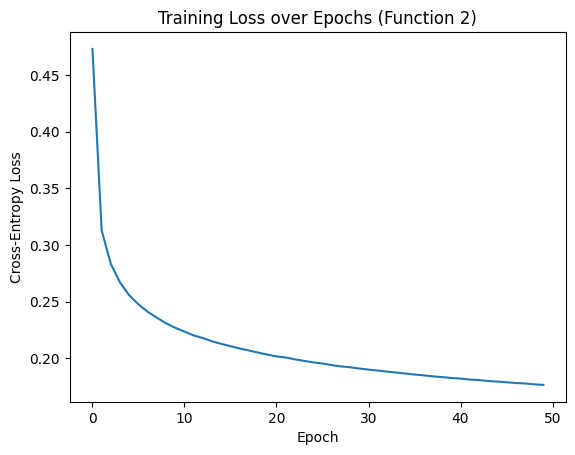

Test Loss: 0.2048, Test Accuracy: 94.49%


In [192]:

plt.plot(model2.history['loss'])
plt.title("Training Loss over Epochs (Function 2)")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

test_loss, test_acc = model2.evaluate(X_test_2, y_test_2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

### 8.3 Function 3

set up

60000 28 28
10000 28 28


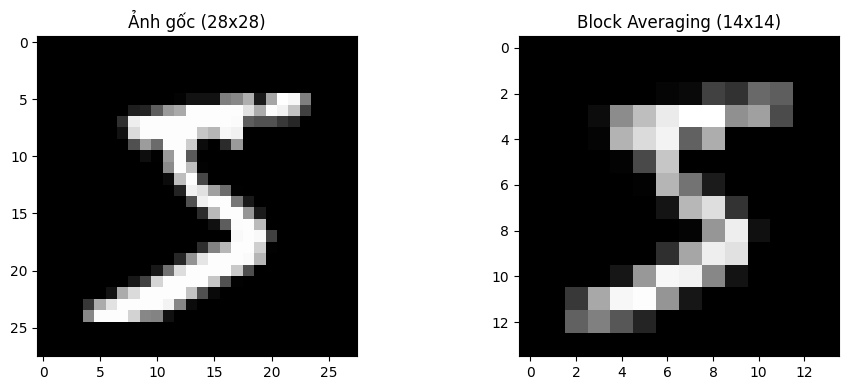

Train shape: (60000, 196), Labels: (60000,)


In [193]:

X_train_3, y_train_3, X_test_3, y_test_3 = function3(X_train, y_train, X_test, y_test)

print(f"Train shape: {X_train_3.shape}, Labels: {y_train_3.shape}")

train

In [194]:
model3 = SoftmaxRegression(
    num_classes=10,
    lr=0.1,
    num_epochs=50,
    batch_size=128
)

print("\nTraining:")
model3.fit(X_train_3, y_train_3)


Training:


Epoch 1/50 - loss=0.9411 - train_acc=0.8635
Epoch 11/50 - loss=0.3450 - train_acc=0.9042
Epoch 21/50 - loss=0.3179 - train_acc=0.9111
Epoch 31/50 - loss=0.3061 - train_acc=0.9131
Epoch 41/50 - loss=0.2990 - train_acc=0.9157


Test

In [195]:
print("\nTest:")
predictions = model3.predict(X_test_3)
acc = calculate_accuracy(y_test_3, predictions)
print(f"Test Accuracy: {acc * 100:.2f}%")


Test:
Test Accuracy: 91.84%


Trực quan hoá và báo cáo kết quả

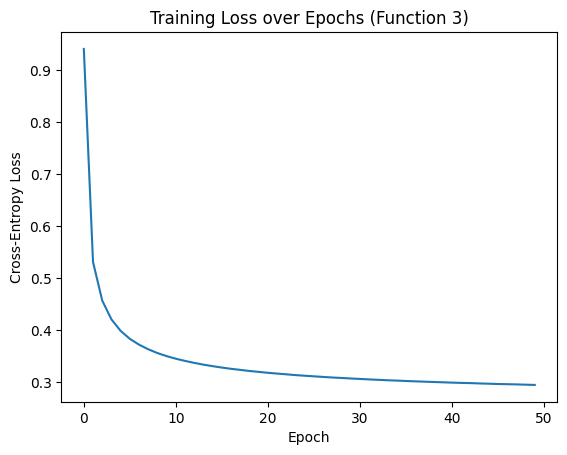

Test Loss: 0.2853, Test Accuracy: 91.84%


In [196]:

plt.plot(model3.history['loss'])
plt.title("Training Loss over Epochs (Function 3)")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

test_loss, test_acc = model3.evaluate(X_test_3, y_test_3)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

In [197]:
# Lưu model

# 1. Model Pixel (Function 1)
np.savez('weights_pixel.npz', W=model.W, b=model.b)

# 2. Model Sobel (Function 2)
np.savez('weights_sobel.npz', W=model2.W, b=model2.b)

# 3. Model Block Average (Function 3)
# Giả sử biến model này là 'model3' như trong notebook
np.savez('weights_block.npz', W=model3.W, b=model3.b)

print("✅ Đã lưu đủ 3 bộ não: Pixel, Sobel, Block!")

✅ Đã lưu đủ 3 bộ não: Pixel, Sobel, Block!
